In [0]:
import IPython.display as ipd
import soundfile as sf
from python_speech_features import mfcc
import numpy as np
import os, shutil
from scipy import signal

In [0]:
wav_input_shape=8000*5#(10, 8000)
mfcc_input_shape=(10, 1287)

hidden_dim=32
output_dim=8000


if os.name=="nt":
  data_source="data\\"
  data_processing="C:\\Users\\Dima\\rrrr\\dihart_processing\\"
else:
  data_source='/content/drive/My Drive/Colab Notebooks/dihard/data/'
  data_processing="./processing/"

batch_size=128

In [0]:
def get_files_list(data_source_dir):
    '''
    returns list of triplets of files (flac_file,rttm_file,sad_file)
    assumes to have in data_source_dir at least three folders: flac,rttm,sad
    '''
    if os.name=="nt":
        sep="\\"
    else:
        sep="/"
    
    sound_files=os.listdir(data_source_dir+"flac")
    files_index=[]
    for f in sound_files:
        fname=os.path.splitext(f)[0]
        flac_file=data_source_dir+"flac"+sep+fname+'.flac'
        rttm_file=data_source_dir+"rttm"+sep+fname+'.rttm'
        sad_file=data_source_dir+"sad"+sep+fname+".lab"
        #check file existance
        if (os.path.isfile(flac_file) *
            os.path.isfile(rttm_file) *
            os.path.isfile(sad_file)):
            files_index.append([flac_file,rttm_file,sad_file])
        else:
            print(fname+" has 1 or two files missed. skipped.")
    return files_index

In [0]:
def load_rttms(filename,length,sr):
    '''
    parses rttm file. Cretaes numpy array for each speaker. 1 - speaker is talking, 0 - speaker is not talking
    @params:
    filename - rttm filename
    length - length of respective flac file in frames
    sr - sample rate
    '''
    with open(filename, 'r') as f:
        content = f.readlines()
    speakers=[]
    rttms=[]
    #last_stop=0
    #i=0
    for line in content:
        data=line.split()
        start=float(data[3])
        duration=float(data[4])
        #print(data[7][7:])
        try:
            speaker=data[7]
        except:
            print("minor error processing speaker in "+filename+" "+data[7])
            speaker=0
        
        #check overlay
        #if start<last_stop: print("overlay! Duration:",last_stop-start," starts at ", start, ", line ",i)
        #last_stop=start+duration
        #i=i+1     
    
        #check if it is a new speaker
        if not speaker in speakers:
            #cretae a new channel for new speaker
            speakers.append(speaker)
            rttms.append(np.zeros(length))
        #find speaker_id and fill respective segment with ones
        speaker_id=speakers.index(speaker)
        rttms[speaker_id][int(start*sr):int((start+duration)*sr)]=1
    return np.array(rttms), speakers        

In [0]:
def separate_speaker(wave, rttms, speaker_id,no_overlay=False,remove_silence=False):
    '''
    returns concatenated speech of particular speaker only 
    no_overlay - to avoid overlays with other speakers
    remove_silence - to remove silence :)
    '''
    if speaker_id>rttms.shape[0]:
        print("No speaker ",speaker_id)
        return None
    
    new_wave=wave*rttms[speaker_id]
    if no_overlay:
        others=np.delete(rttms, (speaker_id), axis=0)
        others=others.sum(axis=0)
        others_invert=np.array([0 if a>0 else 1 for a in others ])
        new_wave=new_wave*others_invert
        
    if remove_silence:
        return new_wave[new_wave!=0]
    return new_wave

In [0]:
def apply_sliding_window(wave_file,lenght,increment):
    '''
    generates sequence of overlayed time windows
    is not used. for LSTM only
    '''
    start_idx=0
    end_idx=lenght
    first_run=True
    while end_idx<=len(wave_file):
    #print(str(start_idx)+':'+str(end_idx))
        d=wave_file[start_idx:end_idx]
        d = np.expand_dims(d, axis=0)
        if first_run:
            out_features=d
            first_run=False
        else:
            out_features=np.concatenate((out_features, d),axis=0)

        start_idx=start_idx +increment
        end_idx=end_idx+increment
    return out_features

In [0]:
def get_mfccs(windows,sr):
    '''
    returns array of MFCC for array of windows
    !!flattens!! MFCC to 1 dimentional array for LSTM
    '''
    mfccs=[]
    for w in windows:
        m=mfcc(w,samplerate=sr)
        m=m.ravel()
        mfccs.append(m)
    return np.array(mfccs)
#==============================================================
def get_mfccs_no_flat(windows,sr):
    '''
    returns array of MFCC for array of windows
    !! does not flat!! MFCC to 1 dimention
    '''
    mfccs=[]
    for w in windows:
        m=mfcc(w,samplerate=sr)
       # m=m.ravel()
        mfccs.append(m)
    return np.array(mfccs)


#==============================================================

def downsample(audio,sr,target_sr):
    '''
    downsamples original audio array to target sample rate.
    scipy works very (extremely) slow :-/
    '''
    if sr==target_sr:
        return audio,sr
    
    if sr==16000 and target_sr==8000:
        return audio[::2],target_sr
    else:
        print("using sloooooooow downsampling")
        secs = len(audio)/sr # Number of seconds in signal X
        samps = int(secs*target_sr)     # Number of samples to downsample
        resampled = signal.resample(audio, samps)
        return resampled, target_sr

In [0]:
def preprocess_files_siam(data_source_dir,data_processing_dir,input_shape,
                     float_rate='float32',targer_sr=8000,window_len=8000,limit=0,save_mfcc=True,num_mfcc_feratures=26):
    '''
    preprocess raw files (wav and rttm) and saves separate numpy files.
    1 output file = 1 person
    '''
    
    sound_files=get_files_list(data_source_dir)
    if limit==0: limit=len(sound_files)

    for f in sound_files[:limit]:
        print("\n",f[0],end=": ")
        good_file=False
        fname=os.path.splitext(os.path.basename(f[0]))[0]

        raw_file,sr=sf.read(f[0],dtype=float_rate)
        raw_file,sr = downsample(raw_file,sr,target_sr=targer_sr)
        rttms,speaker_list=load_rttms(f[1],len(raw_file),window_len)

        for speaker,speaker_name in zip(range(rttms.shape[0]),speaker_list):
            speech=separate_speaker(raw_file,rttms,speaker,no_overlay=True,remove_silence=True)
            #print(len(speech)/8000)
            if len(speech)>4*input_shape:
                #scaling to [0..1]
                #speech=(speech-speech.min())/(speech.max()-speech.min())
                #save this speech in separate file
                if save_mfcc:
                    m=mfcc(speech,sr,numcep=num_mfcc_feratures)
                    m=scale_by_range(m)
                    np.save(data_processing_dir+fname+"_"+speaker_name+".mfcc.npy",m)
                else:pass
                np.save(data_processing_dir+fname+"_"+speaker_name+".wav.npy",speech)
                print(speaker_name,":",len(speech),end=", ")
    print("Done")

In [0]:
def train_test_split(data_processing_dir,test_size=0.2):
    '''
    creates "test" folder inside the processing dir and moves few random files there
    '''
    if os.name=="nt":
        sep="\\"
    else:
        sep="/"

    if not os.path.exists(data_processing_dir+"test"):
            os.makedirs(data_processing_dir+"test")
    speech_f=os.listdir(data_processing_dir)
    speech_files=np.array([f for f in speech_f if ".wav" in f])
    mfcc_files=np.array([f[:f.index(".wav")]+".mfcc.npy" for f in speech_files])  
    #check the order
    for w,m in zip(speech_files,mfcc_files):
        if not w[:w.index(".wav")]==m[:m.index(".mfcc")]:
            print("Something went wrong with damn files")
    test_qty=int(len(speech_files)*test_size)

    test_indices=np.array(range(len(speech_files)))
    test_indices=np.random.permutation(test_indices)[:test_qty]

    for i in test_indices:
        shutil.move(data_processing_dir+speech_files[i], data_processing_dir+'test'+sep+speech_files[i])
        shutil.move(data_processing_dir+mfcc_files[i], data_processing_dir+'test'+sep+mfcc_files[i])

    print("DONE.\nTotal files:",len(speech_files),". Test files:",test_qty)  

In [0]:
def audio_sequence(speech,input_shape):
    '''
    returns sequence of needed shape
    overlayed 50% (hardcoded)
    Is not used. for LSTM only
    '''
    start_point=np.random.randint(speech.shape[0]-input_shape[1]*input_shape[0])
    sequence=[]
    for i in range(input_shape[0]):
        start=start_point+i*input_shape[1]//2
        stop =start+input_shape[1]
        sound=speech[start:stop]
        #print(len(sound))
        sequence.append(sound)
    sequence=np.array(sequence)
    if sequence.shape!=input_shape: print("problem",sequence.shape)
    return sequence

In [0]:
def random_segment(in_speech,length):
    '''
    returns random part of the imput speech of needed shape
    '''
    start_point=np.random.randint(in_speech.shape[0]-length)
    return in_speech[start_point:start_point+length]

def random_segment_wav_mfcc(in_speech,in_mfcc,length):
    '''
    returns sequence of needed shape.
    returns wav and respective mfcc chunk
    '''
    coef=40000/499 # coefficient of transformation wav to mfcc
    start_point_wav=np.random.randint(in_speech.shape[0]-length)
    start_point_mfcc=round(start_point_wav/coef)
    #print(start_point_wav,start_point_mfcc,length,round(length/coef) )
    return in_speech[start_point_wav:start_point_wav+length], in_mfcc[start_point_mfcc:start_point_mfcc+round(length/coef)]


def scale_by_range(x):
    return (x-x.min())/(x.max()-x.min())

def data_generator_siam_precomputed(data_processing_dir,batch_size,input_shape,mfcc_len,num_files=10,verbose=0,sr=8000, num_feratures=26,mfcc_only=False):
    '''
        data generator. Has an option to return MFCC only or both mfcc and wav
    '''
    while 1:
        speech_f=os.listdir(data_processing_dir)
        speech_files=np.array([f for f in speech_f if ".wav" in f])
        mfcc_files=np.array([f[:f.index(".wav")]+".mfcc.npy" for f in speech_files])
        #check the order
        for w,m in zip(speech_files,mfcc_files):
            if not w[:w.index(".wav")]==m[:m.index(".mfcc")]:
                print("Something went wrong with damn files")
                return(None)
        
        #pick %num_files random files for creating batch
        files_index=np.random.permutation(range(len(speech_files)))[:num_files]
        files=speech_files[files_index]
        files_m=mfcc_files[files_index]
        if verbose:print(files,"\n\n",files_m)
        speeches=[]
        mfccs=[]
        #loading files into the RAM
        for f,m in zip(files,files_m):
            speech=np.load(data_processing_dir+f)
            mf=np.load(data_processing_dir+m)
            
            speeches.append(speech)
            mfccs.append(mf)
            
        pairs=[]  
        mfcc_pairs=[]
        labels=[]
        #info=[]
        #generating the batch
        for i in range(batch_size//2):
            #generating positive pair

            #pick random file
            rnd=np.random.randint(num_files)
            rnd_speech=speeches[rnd]
            rnd_mfcc = mfccs[rnd]
            
            s_pos1,m_pos1=random_segment_wav_mfcc(rnd_speech,rnd_mfcc,input_shape)
            s_pos2,m_pos2=random_segment_wav_mfcc(rnd_speech,rnd_mfcc,input_shape)
            
            #m_pos1=mfcc(s_pos1,sr,numcep=num_feratures)
            #m_pos2=mfcc(s_pos2,sr,numcep=num_feratures)
            #m_pos1=scale_by_range(m_pos1)
            #m_pos2=scale_by_range(m_pos2)
            
            pair_pos=np.array([s_pos1,s_pos2])
            mfcc_pair_pos=np.array([m_pos1,m_pos2])
            #print(pair.shape,end="")
            pairs.append(pair_pos)
            mfcc_pairs.append(mfcc_pair_pos)
            labels.append(0)   
            #info.append(files[rnd]+","+str(rs1)+" "+str(rs2))

            #generating negative pair
            rnd_pair=np.random.permutation(range(num_files))[:2]
           #print(rnd_pair)
            rnd_speech1=speeches[rnd_pair[0]]
            rnd_speech2=speeches[rnd_pair[1]]
            rnd_mfcc1 = mfccs[rnd_pair[0]]
            rnd_mfcc2 = mfccs[rnd_pair[1]]
            

            s_neg1,m_neg1=random_segment_wav_mfcc(rnd_speech1,rnd_mfcc1,input_shape)
            s_neg2,m_neg2=random_segment_wav_mfcc(rnd_speech2,rnd_mfcc2,input_shape)
            
            #m_neg1=mfcc(s_neg1,sr,numcep=num_feratures)
            #m_neg2=mfcc(s_neg2,sr,numcep=num_feratures)
            #m_neg1=scale_by_range(m_neg1)
            #m_neg2=scale_by_range(m_neg2)            
            
            pair_neg=np.array([s_neg1,s_neg2])
            mfcc_pair_neg=np.array([m_neg1,m_neg2])
            #print(pair.shape,end="")
            pairs.append(pair_neg)
            mfcc_pairs.append(mfcc_pair_neg)
            labels.append(1)  
            #info.append(files[rnd_pair[0]]+":"+files[rnd_pair[1]])
            #print(mfcc_pair1.shape,mfcc_pair2.shape)
                       
        pairs=np.array(pairs)
        mfcc_pairs=np.array(mfcc_pairs)
        mfcc_pairs=mfcc_pairs.reshape((*mfcc_pairs.shape,1))
        
        labels=np.array(labels)
        
        left_wav=pairs[:,0]
        left_mfcc=mfcc_pairs[:,0]
        
        right_wav=pairs[:,1]
        right_mfcc=mfcc_pairs[:,1]
        
        if mfcc_only:
            yield [left_mfcc,right_mfcc], labels
        else:
            yield [left_wav,left_mfcc,right_wav,right_mfcc], labels

In [0]:
#test the generator
gen=data_generator_siam_precomputed(data_processing,16,input_shape=40000,mfcc_len=499,num_files=10,verbose=1,sr=8000,mfcc_only=False)

In [0]:
%%time
x,y=gen.__next__()

['DH_0047_speaker28.wav.npy' 'DH_0067_speaker70.wav.npy'
 'DH_0025_speaker5.wav.npy' 'DH_0048_speaker30.wav.npy'
 'DH_0069_speaker100.wav.npy' 'DH_0056_speaker24.wav.npy'
 'DH_0024_speaker4.wav.npy' 'DH_0046_speaker27.wav.npy'
 'DH_0030_speaker4.wav.npy' 'DH_0059_speaker55.wav.npy'] 

 ['DH_0047_speaker28.mfcc.npy' 'DH_0067_speaker70.mfcc.npy'
 'DH_0025_speaker5.mfcc.npy' 'DH_0048_speaker30.mfcc.npy'
 'DH_0069_speaker100.mfcc.npy' 'DH_0056_speaker24.mfcc.npy'
 'DH_0024_speaker4.mfcc.npy' 'DH_0046_speaker27.mfcc.npy'
 'DH_0030_speaker4.mfcc.npy' 'DH_0059_speaker55.mfcc.npy']
Wall time: 174 ms


In [0]:
print(x[3].shape)
print(y)

(16, 499, 26, 1)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [0]:
i=7
#print(inf[i])
print (y[i])
ipd.Audio(x[0][i],rate=8000)

1


In [0]:
ipd.Audio(x[2][i],rate=8000)

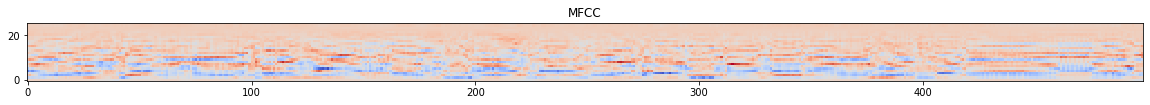

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(figsize=(20, 10))
mfcc_data= np.swapaxes(x[1][i][:,:,0], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()

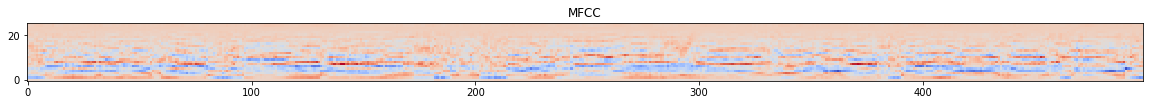

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(figsize=(20, 10))
mfcc_data= np.swapaxes(x[3][i][:,:,0], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()